<a href="https://colab.research.google.com/github/kaushalkuma-r/Operating-System-Lab/blob/main/stroke_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stroke Prediction  Model**


In [44]:
!pip install six

In [45]:
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.22.2.post1


In [46]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score
import time as timer
from sklearn.inspection import permutation_importance



In [47]:
# # the data set suggested by the reference repo does not exist anymore so we need to look for another one. For now I will use the healthcare-dataset-stroke-data.csv.
# #the code below may be useful later
# from google.colab import drive
# drive.mount('/content/drive')

In [48]:
! pip install kaggle

In [49]:
#load dataset from kaggle or elsewhere
url = "https://gist.githubusercontent.com/aishwarya8615/d2107f828d3f904839cbcb7eaa85bd04/raw/cec0340503d82d270821e03254993b6dede60afb/healthcare-dataset-stroke-data.csv"
data = pd.read_csv(url)
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [50]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [51]:
miss_val = data.isnull().sum()/len(data)*100
print(miss_val)
print("# Missing values in variable bmi\t\t: {:.2f}%".format(miss_val['bmi']))
print("# Missing values in variable smoking_status\t: {:.2f}%".format(miss_val['smoking_status']))
print("Data shape: {}".format(data.shape))

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64
# Missing values in variable bmi		: 3.93%
# Missing values in variable smoking_status	: 0.00%
Data shape: (5110, 12)


In [52]:
# Safely disable new warning with the chained assignment.
pd.options.mode.chained_assignment = None  # default='warn'
# replace missing values in variable 'bmi' with its mean
data['bmi']=data['bmi'].fillna(data['bmi'].mean())
# remove (drop) data associated with missing values in variable 'smoking_status'
clean_data = data[data['smoking_status'].notnull()]
# drop variable 'id'
clean_data.drop(columns='id',axis=1,inplace=True)
# validate there's no more missing values
miss_val = clean_data.isnull().sum()/len(clean_data)*100
print(miss_val)
print("# Missing values in variable 'bmi'\t\t: {}".format(miss_val['bmi']))
print("# Missing values in variable 'smoking_status'\t: {}".format(miss_val['smoking_status']))
print("Shape of data without missing values: {}".format(clean_data.shape))

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64
# Missing values in variable 'bmi'		: 0.0
# Missing values in variable 'smoking_status'	: 0.0
Shape of data without missing values: (5110, 11)


In [53]:
print("Unique 'gender': {}".format(clean_data['gender'].unique()))
print("Unique 'ever_married': {}".format(clean_data['ever_married'].unique()))
print("Unique 'work_type': {}".format(clean_data['work_type'].unique()))
print("Unique 'Residence_type': {}".format(clean_data['Residence_type'].unique()))
print("Unique 'smoking_status': {}".format(clean_data['smoking_status'].unique()))

Unique 'gender': ['Male' 'Female' 'Other']
Unique 'ever_married': ['Yes' 'No']
Unique 'work_type': ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Unique 'Residence_type': ['Urban' 'Rural']
Unique 'smoking_status': ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [54]:
# create encoder for each categorical variable
label_gender = LabelEncoder()
label_married = LabelEncoder()
label_work = LabelEncoder()
label_residence = LabelEncoder()
label_smoking = LabelEncoder()

In [55]:
clean_data['gender'] = label_gender.fit_transform(clean_data['gender'])
clean_data['ever_married'] = label_married.fit_transform(clean_data['ever_married'])
clean_data['work_type']= label_work.fit_transform(clean_data['work_type'])
clean_data['Residence_type']= label_residence.fit_transform(clean_data['Residence_type'])
clean_data['smoking_status']= label_smoking.fit_transform(clean_data['smoking_status'])
with pd.option_context('expand_frame_repr', False):
    print(clean_data.head())

   gender   age  hypertension  heart_disease  ever_married  work_type  Residence_type  avg_glucose_level        bmi  smoking_status  stroke
0       1  67.0             0              1             1          2               1             228.69  36.600000               1       1
1       0  61.0             0              0             1          3               0             202.21  28.893237               2       1
2       1  80.0             0              1             1          2               0             105.92  32.500000               2       1
3       0  49.0             0              0             1          2               1             171.23  34.400000               3       1
4       0  79.0             1              0             1          3               0             174.12  24.000000               2       1


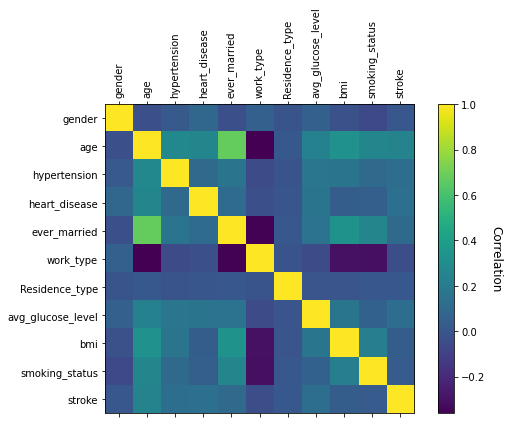

In [56]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.matshow(clean_data.corr())
ax.set_xticks(np.arange(clean_data.shape[1]))
ax.set_yticks(np.arange(clean_data.shape[1]))
ax.set_xticklabels(clean_data.columns,rotation=90)
ax.set_yticklabels(clean_data.columns)
# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom", fontsize=12)
fig.tight_layout()
plt.show()

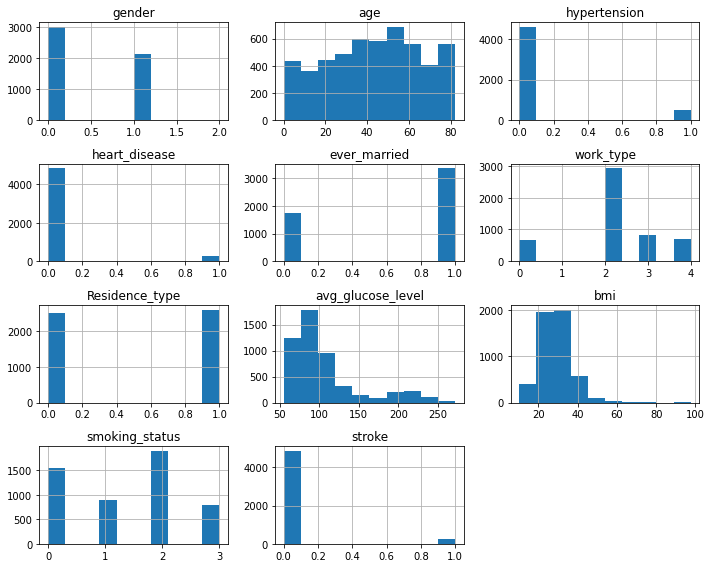

In [57]:
fig = clean_data.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

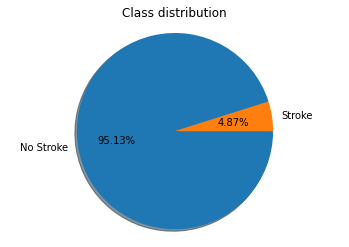

# samples associated with no stroke: 4861
# samples associated with stroke: 249


In [60]:
class_occur = clean_data['stroke'].value_counts()
class_names = ['No Stroke','Stroke']
fig, ax = plt.subplots()
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=0, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()
print("# samples associated with no stroke: {}".format(class_occur[0]))
print("# samples associated with stroke: {}".format(class_occur[1]))

In [61]:
# create the  object with the desired sampling strategy.
smote = SMOTE(sampling_strategy='minority')

# fit the object to our training data
X, y = smote.fit_sample(clean_data.loc[:,clean_data.columns!='stroke'], clean_data['stroke'])
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (9722, 10)
Shape of y: (9722,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


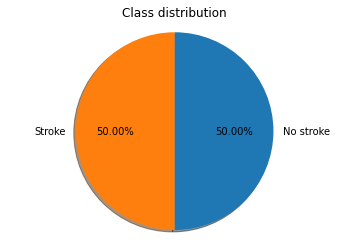

# samples associated with no stroke: 4861
# samples associated with stroke: 4861


In [62]:
_, class_counts = np.unique(y, return_counts=True)
class_names = ['No stroke', 'Stroke']
fig, ax = plt.subplots()
ax.pie(class_counts, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=90, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()
print("# samples associated with no stroke: {}".format(class_counts[0]))
print("# samples associated with stroke: {}".format(class_counts[1]))

In [63]:
def split_train_valid_test(X,y,test_size=0.1,random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=test_size/(1-test_size), random_state=random_state, stratify=y_train)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(X,y,test_size=0.1,random_state=42)
_, train_counts = np.unique(y_train, return_counts=True)
_, valid_counts = np.unique(y_valid, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
print("[train] # class 0: {} | # class 1: {}".format(train_counts[0],train_counts[1]))
print("[valid] # class 0: {} | # class 1: {}".format(valid_counts[0],valid_counts[1]))
print("[test]  # class 0: {} | # class 1: {}".format(test_counts[0],test_counts[1]))

[train] # class 0: 3888 | # class 1: 3888
[valid] # class 0: 486 | # class 1: 487
[test]  # class 0: 487 | # class 1: 486


In [64]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)
X_test_std = scaler.transform(X_test)

In [65]:
def calc_sens_spec(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true,y_pred)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    # calculate the sensitivity
    sensitivity = TP / (TP + FN)    
    # calculate the specificity
    specificity = TN / (TN + FP)
    return sensitivity,specificity

In [66]:
start = timer.time()
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_xgb = xgb_model.predict(X_test_std)
y_xgb_prob = xgb_model.predict_proba(X_test_std)

Finished training within 0.64 seconds


Classification report for XGB: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       487
           1       1.00      0.94      0.97       486

    accuracy                           0.97       973
   macro avg       0.97      0.97      0.97       973
weighted avg       0.97      0.97      0.97       973

Confusion matrix for XGB: 
[[487   0]
 [ 29 457]]
Accuracy score for XGB: 0.97
Precision score for XGB: 1.00
Recall score for XGB: 0.94
F1 score for XGB: 0.97
Sensitivity score for XGB: 0.94
Specitivity score for XGB: 1.00
AUC score for XGB: 0.99


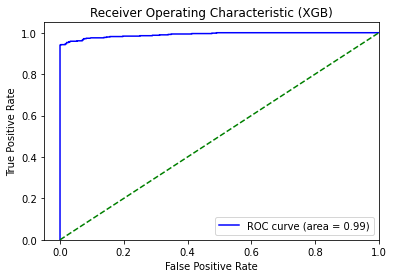

In [67]:

print("Classification report for XGB: \n{}".format(classification_report(y_test,y_xgb)))
print("Confusion matrix for XGB: \n{}".format(confusion_matrix(y_test,y_xgb)))
print("Accuracy score for XGB: {:.2f}".format(accuracy_score(y_test,y_xgb)))
# calculate precision, recall, and f1 scores
prec_xgb = precision_score(y_test,y_xgb)
rec_xgb = recall_score(y_test,y_xgb)
f1_xgb = f1_score(y_test,y_xgb)
print("Precision score for XGB: {:.2f}".format(prec_xgb))
print("Recall score for XGB: {:.2f}".format(rec_xgb))
print("F1 score for XGB: {:.2f}".format(f1_xgb))
# calculate sensitivity, specificity, and auc
sens_xgb,spec_xgb = calc_sens_spec(y_test,y_xgb)
fpr, tpr, _ = roc_curve(y_test,  y_xgb_prob[:,1])
auc_xgb = roc_auc_score(y_test, y_xgb_prob[:,1])
print("Sensitivity score for XGB: {:.2f}".format(sens_xgb))
print("Specitivity score for XGB: {:.2f}".format(spec_xgb))
print("AUC score for XGB: {:.2f}".format(auc_xgb))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_xgb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (XGB)')
ax.legend(loc="lower right")
plt.show()